In [1]:
# Essential imports
import pandas as pd
import numpy as np
import time

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')


# Data processing imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

# Handling imbalance
from imblearn.over_sampling import SMOTE

# Evaluation metric imports
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    log_loss,
    mean_squared_error
)


In [2]:

file_path = '/users/2/vargh085/Variant III.csv'

# Load the dataset using pandas
import pandas as pd
df = pd.read_csv(file_path)

df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,x1,x2
0,0,0.5,0.489311,24,20,50,0.019819,-0.857899,AC,1842,...,0,INTERNET,1.873109,other,0,1,0,0,-0.351078,-0.429230
1,0,0.9,0.535394,-1,82,40,0.007959,-1.560356,AB,1241,...,0,INTERNET,20.170591,linux,1,1,0,0,-0.424817,0.394155
2,0,0.5,0.188964,-1,73,60,0.027117,-0.897317,AC,1095,...,0,INTERNET,1.722109,other,1,1,0,0,-1.974833,0.332406
3,0,0.4,0.391397,29,5,20,0.021103,-0.473215,AB,888,...,0,INTERNET,2.152433,linux,1,1,0,0,-0.579442,0.427254
4,0,0.1,0.592711,-1,267,40,0.039380,16.213862,AA,599,...,0,INTERNET,14.204698,other,0,1,0,0,1.915776,1.363967


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [4]:
# Display data types
print(df.dtypes.value_counts())

# List of categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

int64      18
float64    11
object      5
dtype: int64
Categorical columns: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
Numerical columns: ['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'x1', 'x2']


In [5]:
from sklearn.model_selection import train_test_split

# Stratified sampling 
df_sampled, _ = train_test_split(df, train_size=750000, stratify=df['fraud_bool'], random_state=42)

# Reset index after sampling
df_sampled = df_sampled.reset_index(drop=True)

# Check the shape and class distribution
print("\nSampled DataFrame Shape:", df_sampled.shape)
print("Class Distribution in Sampled Data:")
print(df_sampled['fraud_bool'].value_counts(normalize=True))


Sampled DataFrame Shape: (750000, 34)
Class Distribution in Sampled Data:
0    0.988969
1    0.011031
Name: fraud_bool, dtype: float64


In [6]:
# Get categorical columns directly from df_sampled to ensure they exist
categorical_cols_sampled = df_sampled.select_dtypes(include=['object']).columns.tolist()
print("\nCategorical Columns in Sampled Data:", categorical_cols_sampled)

# One-Hot Encoding with updated categorical columns
df_encoded = pd.get_dummies(df_sampled, columns=categorical_cols_sampled, drop_first=True)

# Update list of numerical columns after encoding
numerical_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('fraud_bool')  # Exclude target variable
print("\nNumerical Columns after Encoding:", numerical_cols)

# Check data types of all columns
print("\nData Types After Encoding:")
print(df_encoded.dtypes.value_counts())



Categorical Columns in Sampled Data: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

Numerical Columns after Encoding: ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'x1', 'x2']

Data Types After Encoding:
uint8      21
int64      18
float64    11
dtype: int64


In [7]:
numerical_cols = [cname for cname in df_encoded.loc[:, :'month'].columns if
                  pd.to_numeric(df_encoded[cname], errors='coerce').notna().all() and
                  df_encoded[cname].min() >= 0 and
                  df_encoded[cname].dtype in ['int64', 'float64']]

numerical_cols

['fraud_bool',
 'income',
 'name_email_similarity',
 'customer_age',
 'days_since_request',
 'zip_count_4w',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'proposed_credit_limit',
 'foreign_request',
 'keep_alive_session',
 'device_fraud_count',
 'month']

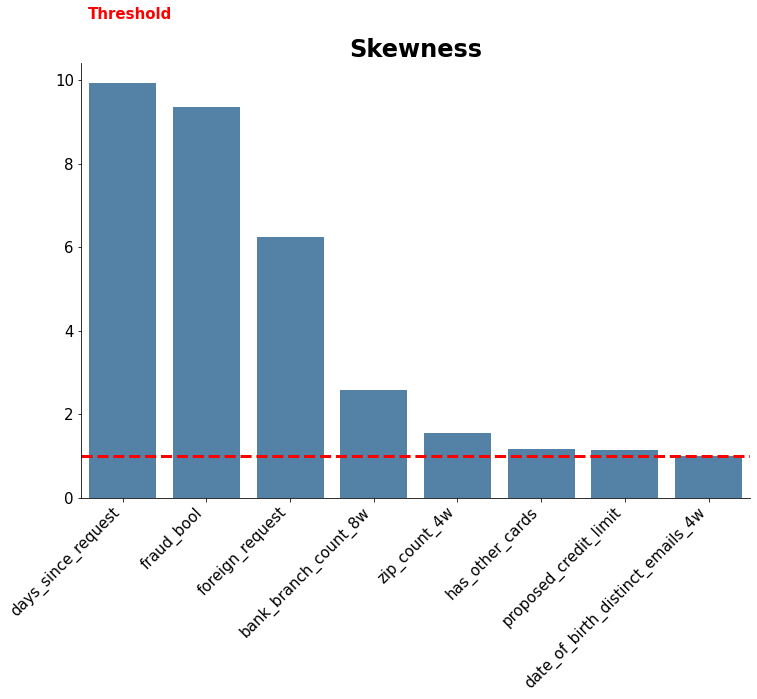

In [8]:
from scipy import stats # Import the stats module from scipy
from scipy.stats import skew

plt.figure(figsize=(12, 8))
skew_features = df_encoded[numerical_cols].apply(lambda x: skew(x))
skew_features = skew_features[skew_features > 0.5].sort_values(ascending=False)
ax = sns.barplot(x=skew_features.index, y=skew_features.values, color='SteelBlue')
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.tick_params(axis='both', labelsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)
ax.axhline(y=1, color='red', linestyle='--', linewidth=3)
ax.set_title('Skewness', ha = 'center', weight='bold', fontsize=24)
ax.text(0.01, 1.1, 'Threshold', color='red', transform=ax.transAxes, fontsize=15, weight='bold')
sns.despine()
plt.gca().set_facecolor('white')
plt.show()

In [9]:
columns_to_transform = ['days_since_request', 'foreign_request','bank_branch_count_8w','has_other_cards','zip_count_4w', 'proposed_credit_limit']

# Apply natural logarithm transformation to specified columns
df_encoded[columns_to_transform] = np.log1p(df_encoded[columns_to_transform])

In [10]:
from sklearn.preprocessing import StandardScaler

# Features to scale (excluding the target variable)
features_to_scale = [col for col in df_encoded.columns if col != 'fraud_bool' and df_encoded[col].dtype != 'bool']

scaler = StandardScaler()
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Combine features and target
X = df_encoded.drop('fraud_bool', axis=1)
y = df_encoded['fraud_bool']

# Split into training and test sets (with stratification)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# To handle imbalanced classes with SMOTE on the training set
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_full, y_train_full)

# sm = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = sm.fit_resample(X_train_full, y_train_full)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train_full, y_train_full)

# 4. ADASYN
# ada = ADASYN(random_state=42)
# X_train_resampled, y_train_resampled = ada.fit_resample(X_train_full, y_train_full)

# Verify the class distribution
print("Class distribution after undersampling:")
# Directly apply value_counts() to the y_train_resampled Series
print(y_train_resampled.value_counts())

Class distribution after undersampling:
1    5791
0    5791
Name: fraud_bool, dtype: int64


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=42)
pca.fit(X_train_resampled)
X_train_pca = pca.transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

In [13]:
from sklearn.svm import SVC

# Initialize the SVM model with a linear kernel
svm_model = SVC(C=1,kernel='rbf',gamma='scale', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train_pca, y_train_resampled)

SVC(C=1, probability=True, random_state=42)


Chosen Threshold for ~5% FPR: 0.7808
Actual FPR at Chosen Threshold: 0.0500
Recall (TPR) at Chosen Threshold: 0.6894

Classification Report at 5% FPR Threshold:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    222518
           1       0.13      0.69      0.22      2482

    accuracy                           0.95    225000
   macro avg       0.56      0.82      0.60    225000
weighted avg       0.99      0.95      0.96    225000



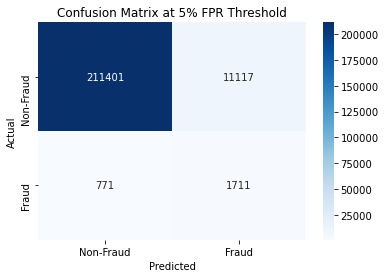

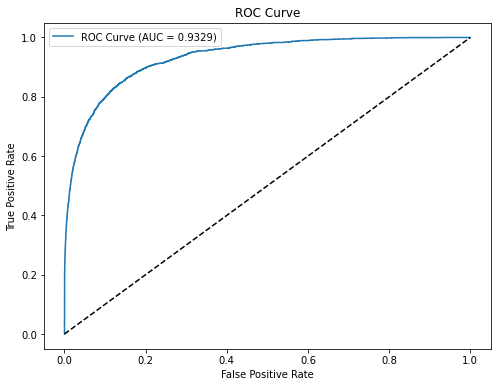

In [14]:
y_scores = svm_model.predict_proba(X_test_pca)[:, 1]
roc_auc = roc_auc_score(y_test, y_scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

target_fpr = 0.05
idx = np.argmin(np.abs(fpr - target_fpr))
chosen_threshold = thresholds[idx]
chosen_fpr = fpr[idx]
chosen_tpr = tpr[idx]

print(f"\nChosen Threshold for ~5% FPR: {chosen_threshold:.4f}")
print(f"Actual FPR at Chosen Threshold: {chosen_fpr:.4f}")
print(f"Recall (TPR) at Chosen Threshold: {chosen_tpr:.4f}")

y_pred_5fpr = (y_scores >= chosen_threshold).astype(int)

print("\nClassification Report at 5% FPR Threshold:")
print(classification_report(y_test, y_pred_5fpr))

cm = confusion_matrix(y_test, y_pred_5fpr)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix at 5% FPR Threshold')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly'],
    'gamma': ['scale', 'auto'],
    'degree': [4,5,6]
    
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVM classifier without specifying hyperparameters
svm = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='roc_auc',            # Evaluation metric
    cv=cv,
    n_jobs=-1,                    # Utilize all available cores
    verbose=2,                    # For detailed logs
    return_train_score=True       # To access training scores
)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [4, 5, 6],
                         'gamma': ['scale', 'auto'], 'kernel': ['poly']},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [16]:
# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Best ROC-AUC score achieved during cross-validation
print(f"\nBest ROC-AUC Score during CV: {grid_search.best_score_:.4f}")

# Access the best estimator
best_svm = grid_search.best_estimator_


Best Hyperparameters:
{'C': 1, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}

Best ROC-AUC Score during CV: 0.9169


In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'gamma': ['scale', 'auto']
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVM classifier without specifying hyperparameters
svm = SVC(probability=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='roc_auc',            # Evaluation metric
    cv=cv,
    n_jobs=-1,                    # Utilize all available cores
    verbose=2,                    # For detailed logs
    return_train_score=True       # To access training scores
)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [18]:
# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Best ROC-AUC score achieved during cross-validation
print(f"\nBest ROC-AUC Score during CV: {grid_search.best_score_:.4f}")

# Access the best estimator
best_svm = grid_search.best_estimator_

Best Hyperparameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Best ROC-AUC Score during CV: 0.9383


In [17]:
# # prompt: in the below plot, increase the font size of axes, labels, legends, lnumbers inside confusion matrix, and keep them side by side  the confusion matrix an d roc curveand save the figure

# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
# import numpy as np

# # Assuming 'y_test', 'y_pred_5fpr', 'fpr', 'tpr', and 'roc_auc' are already defined

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_5fpr)

# # Create subplots with adjusted figure size
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Increased figure size

# # Plot Confusion Matrix
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 22}, # increased font size
#             xticklabels=['Non-Fraud', 'Fraud'],
#             yticklabels=['Non-Fraud', 'Fraud'], ax=axes[0])
# axes[0].set_ylabel('Actual', fontsize=20)
# axes[0].set_xlabel('Predicted', fontsize=20)
# axes[0].set_title('Confusion Matrix at 5% FPR Threshold', fontsize=22)
# axes[0].tick_params(axis='both', which='major', labelsize=18) # increase tick label size

# # Plot ROC Curve
# axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
# axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
# axes[1].set_xlabel('False Positive Rate', fontsize=20)
# axes[1].set_ylabel('True Positive Rate', fontsize=20)
# axes[1].set_title('ROC Curve', fontsize=22)
# axes[1].legend(loc='lower right', fontsize=18) # increase legend font
# axes[1].tick_params(axis='both', which='major', labelsize=18) # increase tick label size

# plt.tight_layout()  # Adjust spacing between subplots
# plt.savefig('svm_base.png') # save the figure
# plt.show()